In [1]:
import cv2
import numpy as np
import scipy.sparse.linalg

import utils

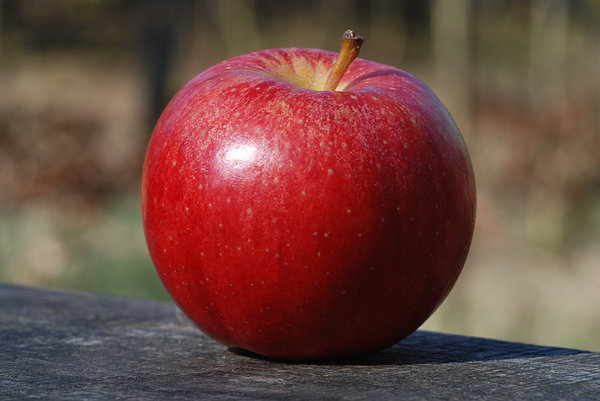

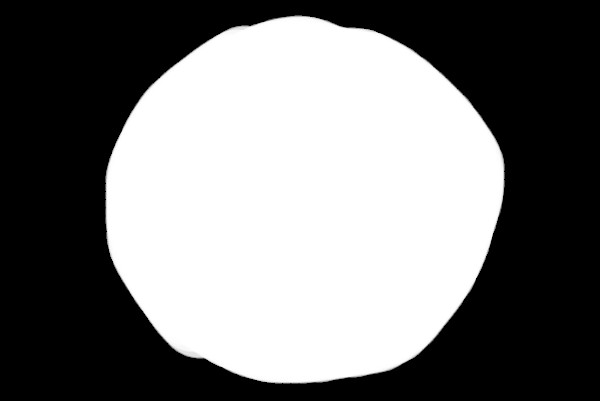

In [2]:
folder_path = "img/ColorChange/"

source = utils.open_and_print_image(folder_path + "source")

mask = utils.open_and_print_image(folder_path + "mask", is_mask=True)

In [3]:
height, width, mask, inner_mask, boundary_mask, pixel_ids, inner_ids, boundary_ids, mask_ids, inner_pos, boundary_pos, mask_pos = utils.setup_variables(mask)
channels = 3

In [4]:
A = utils.create_matrix_A(mask_ids, inner_ids, boundary_ids, inner_pos, boundary_pos, width)

In [5]:
def poisson_color_change_channel(src, target):
    gradients = utils.compute_laplacian(src)

    boundary_pixel_values = utils.get_masked_values(target, boundary_mask).flatten()
    inner_gradient_values = utils.get_masked_values(gradients, inner_mask).flatten()

    # Construct b
    b = utils.construct_b(mask_ids, inner_pos, boundary_pos, inner_gradient_values, boundary_pixel_values)

    # Solve Ax = b
    x = scipy.sparse.linalg.spsolve(A, b)
    
    # reconstruct the new image (single channel)
    new_src = np.zeros_like(src)
    new_src.flat[mask_pos] = x
    img = utils.get_alpha_blended(new_src, target, mask)
    img = np.clip(img, 0, 1)

    return img

In [6]:
# calls the algorithm for each color channel
def poisson_color_change(val):
    #create the color changed version of the source image
    src_hsv = cv2.cvtColor((source * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    src_hsv[:, :, 0] = (src_hsv[:, :, 0] + val) % 180
    src_color_changed = cv2.cvtColor(src_hsv, cv2.COLOR_HSV2RGB).astype(np.float64) / 255

    utils.save_and_print(src_color_changed, folder_path, f"change_{hue_value_chage}.png")

    return np.dstack([poisson_color_change_channel(src_color_changed[..., i], source[..., i]) for i in range(source.shape[-1])])

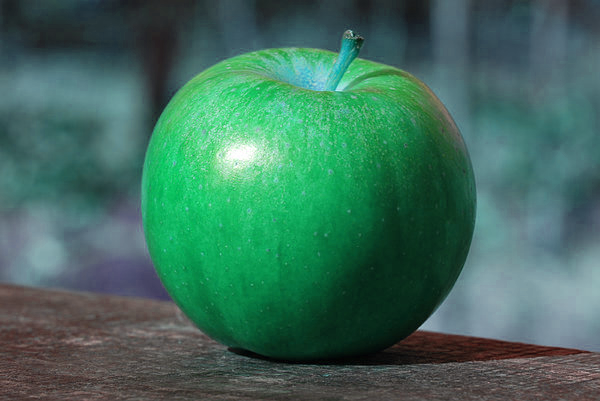

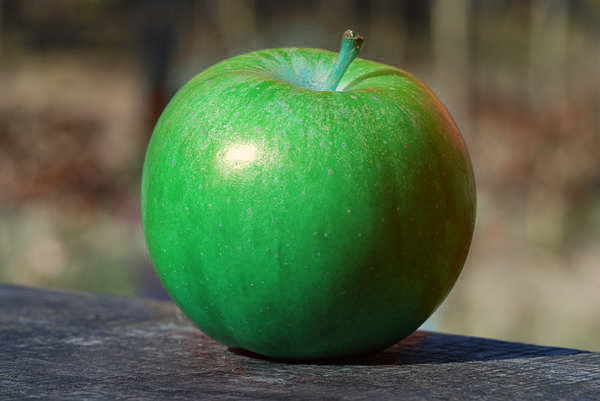

In [7]:
# change this value to change the color offset 
hue_value_chage = 75
img = poisson_color_change(hue_value_chage)
    
utils.save_and_print(img, folder_path, f"result_{hue_value_chage}.png")

# the first image is the original image with just a color change, 
# while the second image is the final result 